In [1]:
!pip install sacrebleu
!pip install transformers==4.20.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 1.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 40.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 83.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.3
    Uninstalling transformers-4.42.3:
      Successfully uninstalled transformers-4.42.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.14.15 requires transformers>=

In [15]:
import os
import datasets
import sacrebleu
import requests
import seaborn as sns
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
from pathlib import Path
from tqdm.auto import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor, as_completed
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTFeatureExtractor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [3]:
os.environ["WANDB_DISABLED"] = "true"
class config : 
    ENCODER = "google/vit-base-patch16-224"
    DECODER = "gpt2"
    TRAIN_BATCH_SIZE = 8
    VAL_BATCH_SIZE = 8
    VAL_EPOCHS = 1
    LR = 5e-5
    SEED = 42
    MAX_LEN = 128
    SUMMARY_LEN = 20
    WEIGHT_DECAY = 0.01
    MEAN = (0.485, 0.456, 0.406)
    STD = (0.229, 0.224, 0.225)
    TRAIN_PCT = 0.95
    NUM_WORKERS = mp.cpu_count()
    EPOCHS = 7
    IMG_SIZE = (224,224)
    LABEL_MASK = -100
    TOP_K = 1000
    TOP_P = 0.95

In [4]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
    bleu_score = sacrebleu.corpus_bleu(pred_str, [label_str])
    return {
        "bleu_score": round(bleu_score.score, 4),
    }

# Preprocess Data

In [5]:
feature_extractor = ViTFeatureExtractor.from_pretrained(config.ENCODER)
tokenizer = AutoTokenizer.from_pretrained(config.DECODER)
tokenizer.pad_token = tokenizer.unk_token

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [6]:
transform = transforms.Compose([
        transforms.Resize(config.IMG_SIZE), 
        transforms.ToTensor(),
        transforms.Normalize(
            mean=0.5,
            std=0.5
        )
])

In [11]:
df = pd.read_csv("../input/food-image-with-caption-bccgoodfood/22k_FoodCaptionData_bbcgoodfood.csv")
df = df[['Description', 'Image URL']].rename(columns={
    "Description": "caption",
    "Image URL": "image"
})
def load_image_from_url(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content)).convert("RGB").resize((224, 224))
        return image
    except Exception as e:
        return None
def fetch_images(df):
    urls = df['image'].tolist()
    images = [None] * len(df)
    with tqdm(total=len(urls), desc="Loading images") as pbar:
        with ThreadPoolExecutor(max_workers=15) as executor:
            futures = {executor.submit(load_image_from_url, url): i for i, url in enumerate(urls)}
            for future in as_completed(futures):
                i = futures[future]
                images[i] = future.result()
                pbar.update(1)
    df['image'] = images
    return df

df = fetch_images(df)
df.dropna(subset=['image', 'caption'], inplace=True)
# df.drop_duplicates(subset=['caption', 'image'], inplace=True)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
print("Length of data: ",len(df))
df.head()

Loading images:   0%|          | 0/22381 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Length of data:  22197


,caption,image
0,Two-minute breakfast smoothie,<PIL.Image.Image image mode=RGB size=224x224 a...
1,Breakfast burrito,<PIL.Image.Image image mode=RGB size=224x224 a...
2,Breakfast egg wraps,<PIL.Image.Image image mode=RGB size=224x224 a...
3,Chorizo & halloumi breakfast baguette,<PIL.Image.Image image mode=RGB size=224x224 a...
4,Breakfast muffins,<PIL.Image.Image image mode=RGB size=224x224 a...


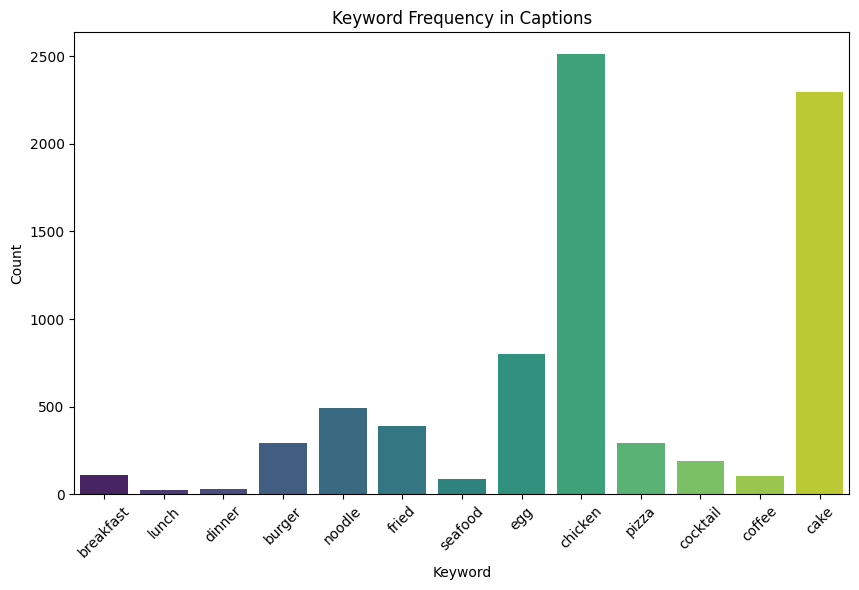

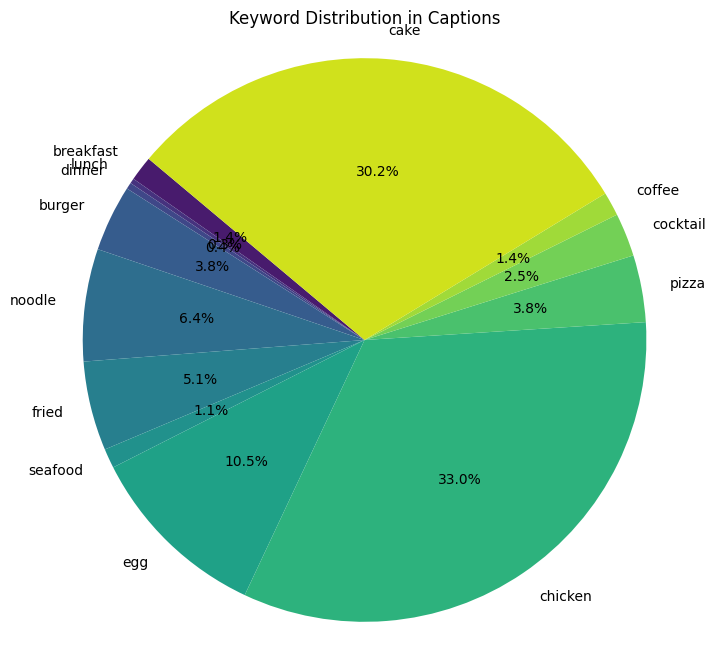

In [16]:
# Danh sách các từ khóa cần đếm
keywords = ['breakfast', 'lunch', 'dinner', 'burger', 'noodle', 'fried', 'seafood', 
            'egg', 'chicken', 'pizza', 'cocktail', 'coffee', 'cake']

# Đếm số lượng xuất hiện của từng từ khóa trong cột caption
counts = {keyword: df['caption'].str.contains(keyword, case=False).sum() for keyword in keywords}

# Chuyển đổi từ điển counts thành DataFrame để dễ xử lý
counts_df = pd.DataFrame(list(counts.items()), columns=['Keyword', 'Count'])

# Vẽ biểu đồ hình cột
plt.figure(figsize=(10, 6))
sns.barplot(x='Keyword', y='Count', data=counts_df, palette='viridis')
plt.title('Keyword Frequency in Captions')
plt.xticks(rotation=45)
plt.show()

# Vẽ biểu đồ hình tròn
plt.figure(figsize=(8, 8))
plt.pie(counts_df['Count'], labels=counts_df['Keyword'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(counts_df)))
plt.title('Keyword Distribution in Captions')
plt.axis('equal')  # Đảm bảo hình tròn không bị méo
plt.show()

In [17]:
class ImgDataset(Dataset):
    def __init__(self, df,root_dir,tokenizer,feature_extractor, transform = None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.tokenizer= tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = 50
    def __len__(self,):
        return len(self.df)
    def __getitem__(self,idx):
        caption = self.df.caption.iloc[idx]
        img = self.df.image.iloc[idx]
        
        if self.transform is not None:
            img= self.transform(img)
        pixel_values = self.feature_extractor(img, return_tensors="pt").pixel_values
        captions = self.tokenizer(caption,
                          padding='max_length',
                          max_length=self.max_length,
                          truncation=True,
                          return_tensors='pt')["input_ids"]
#         captions = [caption if caption != self.tokenizer.pad_token_id else -100 for caption in captions]
        encoding = {
                        "pixel_values": pixel_values.squeeze(),
                        "labels": torch.tensor(captions).clone().detach().squeeze()
                    }
        return encoding

In [18]:
train_dataset = ImgDataset(train_df, root_dir = "../input/dataset/content/dataset",tokenizer=tokenizer,feature_extractor = feature_extractor ,transform = None)
val_dataset = ImgDataset(val_df , root_dir = "../input/dataset/content/dataset",tokenizer=tokenizer,feature_extractor = feature_extractor , transform  = None)

In [20]:
train_dataset[0]

/tmp/ipykernel_34/2631179034.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(captions).clone().detach().squeeze()


{'pixel_values': tensor([[[ 0.4745,  0.4980,  0.5765,  ...,  0.1765,  0.1529,  0.1294],
          [ 0.5608,  0.6549,  0.6549,  ...,  0.1373,  0.1608,  0.1451],
          [ 0.6706,  0.7647,  0.7412,  ...,  0.0980,  0.1137,  0.1529],
          ...,
          [ 0.8588,  0.8431,  0.8745,  ...,  0.5137,  0.5529,  0.5529],
          [ 0.8275,  0.8118,  0.8824,  ...,  0.6627,  0.6549,  0.6549],
          [ 0.7961,  0.8431,  0.8588,  ...,  0.5922,  0.5529,  0.5922]],
 
         [[-0.3333, -0.3255, -0.2863,  ..., -0.4980, -0.5137, -0.5373],
          [-0.2627, -0.1922, -0.2235,  ..., -0.4980, -0.4980, -0.5216],
          [-0.1765, -0.1059, -0.1529,  ..., -0.4980, -0.5373, -0.5137],
          ...,
          [ 0.2549,  0.2078,  0.3020,  ...,  0.1843,  0.2157,  0.2078],
          [ 0.2000,  0.1765,  0.3255,  ...,  0.4039,  0.3804,  0.3804],
          [ 0.1686,  0.2078,  0.3020,  ...,  0.3098,  0.2392,  0.2706]],
 
         [[-0.5216, -0.5059, -0.4510,  ..., -0.5373, -0.5529, -0.5765],
          [-

# Define Model and Fine Tuning

In [11]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(config.ENCODER, config.DECODER)

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.1.crossattention.c_proj.bias', 'h.5.crossattention.q_attn.weight', 'h.2.crossattention.q_attn.weight', 'h.11.ln_cross_attn.weight', 'h.4.ln_cross_attn.weight', 'h.6.ln_cross_attn.weight', 'h.11.crossattention.c_proj.weight', 'h.11.crossattention.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.q_attn.weight', 'h.1.crossattention.c_proj.weight', 'h.7.crossattention.masked_bias', 'h.7.crossattention.q_attn.weight', 'h.6.crossattention.c_proj.weight', 'h.5.crossattention.c_attn.weight', 'h.8.crossattention.bias', 'h.9.crossattention.c_proj.weight', 'h.5.ln_cross_attn.weight', 'h.7.crossattention.c_attn.weight', 'h.10.ln_cross_attn.weight', 'h.3.crossattention.masked_bias', 'h.2.ln_cross_attn.weight', 'h.7.crossattention.c_proj.weight', 'h.3.crossattention.bias', 'h.4.crossattention.q_attn.weight', 'h.10.crossattention.q_attn.weight', 'h.8.crossattention.maske

In [12]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size
# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.max_length = 128
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [13]:
training_args = Seq2SeqTrainingArguments(
    output_dir='VIT_GPT2_ImageCaptioningFood',
    per_device_train_batch_size=config.TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=config.VAL_BATCH_SIZE,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,  
    save_steps=2048, 
    warmup_steps=1024,  
    learning_rate = 5e-5,
    num_train_epochs = config.EPOCHS,
#     num_train_epochs = 3,
    overwrite_output_dir=True,
    save_total_limit=1,
)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [14]:
### instantiate trainer
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 17758
  Num Epochs = 7
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15540
/tmp/ipykernel_34/2631179034.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(captions).clone().detach().squeeze()


Epoch,Training Loss,Validation Loss,Bleu Score
1,0.475500,0.418164,1.315500
2,0.349100,0.327862,3.558100
3,0.234100,0.263366,9.114300
4,0.148600,0.223336,18.930000
5,0.095400,0.195706,37.143200
6,0.056600,0.181178,52.533700
7,0.038900,0.174031,60.152500


Saving model checkpoint to VIT_GPT2_ImageCaptioningFood/checkpoint-2048
Configuration saved in VIT_GPT2_ImageCaptioningFood/checkpoint-2048/config.json
Model weights saved in VIT_GPT2_ImageCaptioningFood/checkpoint-2048/pytorch_model.bin
Feature extractor saved in VIT_GPT2_ImageCaptioningFood/checkpoint-2048/preprocessor_config.json
/tmp/ipykernel_34/2631179034.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(captions).clone().detach().squeeze()
***** Running Evaluation *****
  Num examples = 4440
  Batch size = 8
Saving model checkpoint to VIT_GPT2_ImageCaptioningFood/checkpoint-4096
Configuration saved in VIT_GPT2_ImageCaptioningFood/checkpoint-4096/config.json
Model weights saved in VIT_GPT2_ImageCaptioningFood/checkpoint-4096/pytorch_model.bin
Feature extractor saved in VIT_GPT2_ImageCaptioningFood/checkpo

TrainOutput(global_step=15540, training_loss=0.2332502469439611, metrics={'train_runtime': 7730.9514, 'train_samples_per_second': 16.079, 'train_steps_per_second': 2.01, 'total_flos': 2.243274444957863e+19, 'train_loss': 0.2332502469439611, 'epoch': 7.0})

## Save Model

In [15]:
import zipfile
import os

model_save_path = "/kaggle/working/VIT_GPT2_ImageCaptioningFood"
trainer.save_model(model_save_path)

zip_filename = "VIT_GPT2_ImageCaptioningFood.zip"
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for root, _, files in os.walk(model_save_path):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), os.path.join(model_save_path, '..')))

print(f"Saved trained model to {zip_filename}")

Saving model checkpoint to /kaggle/working/VIT_GPT2_ImageCaptioningFood
Configuration saved in /kaggle/working/VIT_GPT2_ImageCaptioningFood/config.json
Model weights saved in /kaggle/working/VIT_GPT2_ImageCaptioningFood/pytorch_model.bin
Feature extractor saved in /kaggle/working/VIT_GPT2_ImageCaptioningFood/preprocessor_config.json


Saved trained model to VIT_GPT2_ImageCaptioningFood.zip


# Inference

In [18]:
def generate_caption(i, feature_extractor, df):
    true_caption, img =  df.iloc[i]
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    img= transform(img)
    generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to(device))[0], skip_special_tokens=True)
    print('\033[96m' +"Generate caption: " +generated_caption+ '\033[0m')
    print('\033[96m' +"True caption: " +true_caption+ '\033[0m')

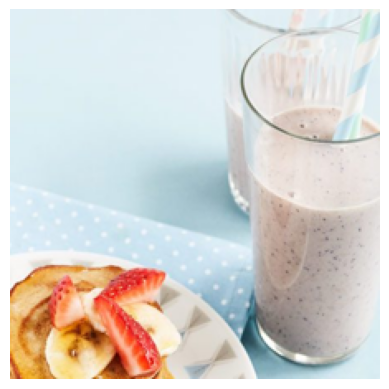

Generate caption: Egg & raspberry smoothie
True caption: Two-minute breakfast smoothie


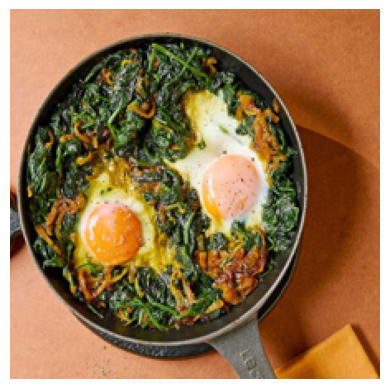

Generate caption: Foil-fryer shakshuka
True caption: Persian spinach & onion fried eggs (nargesi-e esfenaj)


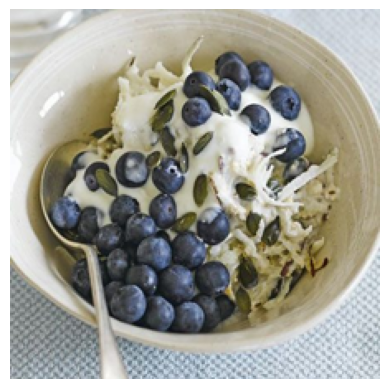

Generate caption: Fruity sorbet
True caption: Pear & blueberry breakfast bowl


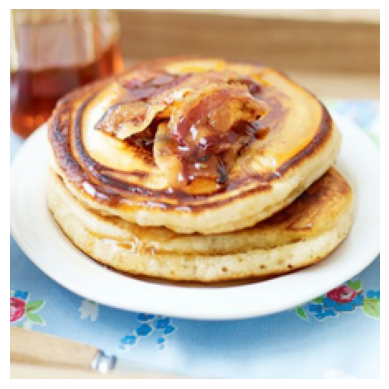

Generate caption: Giant apricot & strawberry cake
True caption: Fluffy American pancakes


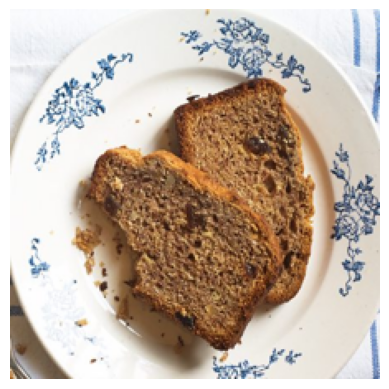

Generate caption: Easy chocolate fudge
True caption: Vegan banana bread


In [25]:
import random
for _ in range(5):
    i = random.randint(0,100)
    generate_caption(i, feature_extractor, df)